In [9]:
from flipside import Flipside
import numpy as np
import pandas as pd 
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [10]:
""" This repo GITIGNORES api_key.txt, use this convention to store your key safely"""

with open('api_key.txt', 'r') as file:
    # Read the first line
    api_key = file.readline().strip()  # .strip() removes newline characters


"""Initialize Flipside with your API Key / API Url"""
flipside = Flipside(api_key, "https://api-v2.flipsidecrypto.xyz")


In [14]:
sql = """WITH RECURSIVE date_series AS (
  SELECT
    '2024-02-01' :: DATE AS day
  UNION
  ALL
  SELECT
    day + INTERVAL '1 day'
  FROM
    date_series
  WHERE
    day < CURRENT_DATE
),
traders AS (
  SELECT
    ORIGIN_FROM_ADDRESS,
    SUM(AMOUNT_OUT_USD) AS Volume
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    ORIGIN_FROM_ADDRESS
  HAVING
    SUM(AMOUNT_OUT_USD) > 10000000
    AND MIN(BLOCK_TIMESTAMP) >= '2024-02-01'
    AND MIN(BLOCK_TIMESTAMP) < '2024-03-01'
  ORDER BY
    SUM(AMOUNT_OUT_USD) DESC
  LIMIT
    500
),
symbols AS (
  SELECT
    DISTINCT SYMBOL,
    COALESCE(
      CONTRACT_ADDRESS,
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
    ) AS token_contract
  FROM
    ethereum.core.ez_balance_deltas
  WHERE
    USER_ADDRESS IN (
      SELECT DISTINCT ORIGIN_FROM_ADDRESS FROM traders
    )
    AND HAS_PRICE = TRUE
),
daily_balances AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    SYMBOL,
    CURRENT_BAL AS daily_balance,
    COALESCE(
      CONTRACT_ADDRESS,
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
    ) AS token_contract,
    BLOCK_TIMESTAMP,
    USER_ADDRESS
  FROM
    ethereum.core.ez_balance_deltas
  WHERE
    USER_ADDRESS IN (
      SELECT DISTINCT ORIGIN_FROM_ADDRESS FROM traders
    )
    AND HAS_PRICE = TRUE
),
ranked_balances AS (
  SELECT
    day,
    SYMBOL,
    daily_balance,
    token_contract,
    USER_ADDRESS,
    ROW_NUMBER() OVER (
      PARTITION BY token_contract, day
      ORDER BY BLOCK_TIMESTAMP DESC
    ) AS rn
  FROM
    daily_balances
),
filtered_balances AS (
  SELECT
    day,
    SYMBOL,
    daily_balance,
    token_contract,
    USER_ADDRESS
  FROM
    ranked_balances
  WHERE
    rn = 1
),
filled_balances AS (
  SELECT
    ds.day,
    s.SYMBOL,
    COALESCE(fb.daily_balance, 0) AS filled_balance,
    fb.USER_ADDRESS,
    CASE
      WHEN s.SYMBOL = 'ETH' THEN LOWER('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
      ELSE fb.token_contract
    END AS token_contract
  FROM
    date_series ds
    CROSS JOIN symbols s
    LEFT JOIN filtered_balances fb ON fb.day <= ds.day
    AND fb.SYMBOL = s.SYMBOL QUALIFY ROW_NUMBER() OVER (
      PARTITION BY ds.day, s.SYMBOL
      ORDER BY fb.day DESC
    ) = 1
),
latest_prices AS (
  SELECT
    DATE_TRUNC('day', hour) AS day,
    TOKEN_ADDRESS,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY PRICE) AS price
  FROM
    ethereum.price.ez_prices_hourly
  GROUP BY
    DATE_TRUNC('day', hour), TOKEN_ADDRESS
),
balances_with_prices AS (
  SELECT
    fb.day,
    fb.SYMBOL,
    fb.filled_balance,
    USER_ADDRESS,
    lp.PRICE AS daily_price,
    fb.filled_balance * lp.PRICE AS value_in_usd
  FROM
    filled_balances fb
    LEFT JOIN latest_prices lp ON lp.TOKEN_ADDRESS = fb.token_contract
    AND lp.day = fb.day
),
aggregated_by_day AS (
  SELECT
    day,
    daily_price,
    SYMBOL,
    USER_ADDRESS,
    SUM(filled_balance) AS total_filled_balance,
    SUM(value_in_usd) AS total_value_in_usd
  FROM
    balances_with_prices
  GROUP BY
    day, SYMBOL, USER_ADDRESS, daily_price
),
aggregated_added AS (
  SELECT
    a.day,
    a.SYMBOL,
    a.daily_price,
    a.total_filled_balance,
    a.USER_ADDRESS,
    a.total_value_in_usd,
    SUM(a.total_value_in_usd) OVER (PARTITION BY a.day, a.USER_ADDRESS) AS total_usd_in_treasury
  FROM
    aggregated_by_day a
  WHERE
    a.day <= CURRENT_DATE - 1
    AND a.daily_price > 0
  ORDER BY
    a.day DESC, a.SYMBOL
),
aggregated_added2 AS (
  SELECT
    *,
    total_value_in_usd / NULLIF(total_usd_in_treasury, 0) AS composition
  FROM
    aggregated_added
  ORDER BY
    day DESC, SYMBOL, USER_ADDRESS
),
daily_returns AS (
  SELECT
    day,
    SYMBOL,
    daily_price,
    composition,
    total_filled_balance,
    total_usd_in_treasury,
    USER_ADDRESS,
    LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day) AS prev_day_price,
    (daily_price - LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day)) / LAG(daily_price) OVER (PARTITION BY SYMBOL ORDER BY day) AS daily_return
  FROM
    aggregated_added2
),
weighted_daily_returns AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    SUM(daily_return * composition) AS weighted_daily_return
  FROM
    daily_returns
  GROUP BY
    day, USER_ADDRESS, daily_return
),
cumulative_returns AS (
  SELECT
    day,
    daily_return,
    weighted_daily_return,
    USER_ADDRESS,
    (1 + weighted_daily_return) AS daily_factor,
    EXP(SUM(LN(1 + weighted_daily_return)) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC)) - 1 AS cumulative_return
  FROM
    weighted_daily_returns
),
base_return AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    cumulative_return AS base_cumulative_return
  FROM
    cumulative_returns
  WHERE
    cumulative_return IS NOT NULL
),
normalized_returns AS (
  SELECT
    day,
    USER_ADDRESS,
    daily_return,
    base_cumulative_return,
    100 + (100 * (base_cumulative_return - FIRST_VALUE(base_cumulative_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC))) AS portfolio_return
  FROM
    base_return
),
return_stats AS (
  SELECT
    day,
    USER_ADDRESS,
    base_cumulative_return,
    portfolio_return,
    AVG(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC) AS avg_daily_return,
    STDDEV(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC) AS stddev_return
  FROM
    normalized_returns
),
sharpe_ratio AS (
  SELECT
    day,
    USER_ADDRESS,
    base_cumulative_return,
    portfolio_return,
    NULLIF((portfolio_return - 0.0430 / 365) / NULLIF(STDDEV(portfolio_return) OVER (PARTITION BY USER_ADDRESS ORDER BY day ASC), 0), 0) AS daily_sharpe_ratio
  FROM
    return_stats
),
trade_counts AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    ORIGIN_FROM_ADDRESS AS USER_ADDRESS,
    COUNT(DISTINCT tx_hash) AS number_of_trades
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    day, ORIGIN_FROM_ADDRESS
),

tokens_traded AS (
  SELECT
    DATE_TRUNC('day', BLOCK_TIMESTAMP) AS day,
    ORIGIN_FROM_ADDRESS AS USER_ADDRESS,
    COUNT(DISTINCT SYMBOL_OUT) AS unique_tokens_traded
  FROM
    ethereum.defi.ez_dex_swaps
  GROUP BY
    day, ORIGIN_FROM_ADDRESS
),

final_normalized_returns AS (
  SELECT
    sr.day,
    sr.USER_ADDRESS,
    sr.base_cumulative_return,
    sr.portfolio_return,
    sr.daily_sharpe_ratio,
    CASE
      WHEN AVG(sr.portfolio_return) > 120 AND sr.daily_sharpe_ratio > 1.5 THEN 'Good Trader'
      WHEN AVG(sr.portfolio_return) BETWEEN 100 AND 120 THEN 'Average Trader'
      WHEN AVG(sr.portfolio_return) < 100 THEN 'Bad Trader'
    END AS trader_class
  FROM
    sharpe_ratio sr
  WHERE
    sr.daily_sharpe_ratio IS NOT NULL
  GROUP BY
    sr.day, sr.USER_ADDRESS, sr.base_cumulative_return, sr.portfolio_return, sr.daily_sharpe_ratio
)

SELECT
  fnr.day,
  fnr.USER_ADDRESS,
  fnr.base_cumulative_return,
  fnr.portfolio_return,
  fnr.daily_sharpe_ratio,
  fnr.trader_class,
  tc.number_of_trades,
  tt.unique_tokens_traded
FROM
  final_normalized_returns fnr
  LEFT JOIN trade_counts tc ON tc.day = fnr.day AND tc.USER_ADDRESS = fnr.USER_ADDRESS
  LEFT JOIN tokens_traded tt ON tt.day = fnr.day AND tt.USER_ADDRESS = fnr.USER_ADDRESS;
"""
"""Run the query against Flipside's query engine and await the results"""
query_result_set = flipside.query(
        sql=sql,
        ttl_minutes=10,
        timeout_minutes=5
    )
print(query_result_set)

ValidationError: 4 validation errors for CreateQueryRunRpcResponse
jsonrpc
  field required (type=value_error.missing)
id
  field required (type=value_error.missing)
error -> code
  field required (type=value_error.missing)
error -> message
  field required (type=value_error.missing)

In [ ]:
"""This function will be added to Flipside package after testing, just copy/paste as needed for now"""
def auto_paginate_result(query_result_set, page_size=10000):
    """
    This function auto-paginates a query result to get all the data. It assumes 10,000 rows per page.
    In case of an error, reduce the page size. Uses numpy.
    """
    num_rows = query_result_set.page.totalRows
    page_count = np.ceil(num_rows / page_size).astype(int)
    all_rows = []
    current_page = 1
    while current_page <= page_count:
        results = flipside.get_query_results(
            query_result_set.query_id,
            page_number=current_page,
            page_size=page_size
        )
        if results.records:
            all_rows.extend(results.records)  # Use extend() to add list elements
        current_page += 1  # Increment the current page number
    return all_rows  # Return all_rows in JSON format


: 

: 

: 

In [ ]:
""" Get your data as a pandas data frame"""

trader_classifier = auto_paginate_result(query_result_set)
df = pd.DataFrame(trader_classifier)

# Set the display option to show all columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)  # Adjusts the display width for better visibility

#Display Dataframe
print(df.head())

                        day                                user_address  \
0  2024-05-10T00:00:00.000Z  0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d   
1  2024-10-12T00:00:00.000Z  0x3e55457808fb552a7f1989d68c9daf5d3a51c027   
2  2024-03-08T00:00:00.000Z  0xda6d5943ae71272518636e24a1da83ad0e5a85dd   
3  2024-09-29T00:00:00.000Z  0xb7dab94552302bcdff309e541d51ad203cbd7042   
4  2024-09-15T00:00:00.000Z  0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c   

   base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
0               -0.049529         93.716634           73.040066   
1               -0.432623         60.820272            3.565700   
2                0.117400        102.807208           68.423993   
3               -0.448353         53.095413            1.806804   
4               -0.837154         14.322205            0.421474   

     trader_class  number_of_trades  unique_tokens_traded  __row_index  
0      Bad Trader               NaN                   NaN            0  


: 

: 

: 

In [ ]:
#Drop the "__row_index" column
df_t = df.drop(columns = ['__row_index'])

#Remove later
print(df_t.head())

                        day                                user_address  \
0  2024-05-10T00:00:00.000Z  0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d   
1  2024-10-12T00:00:00.000Z  0x3e55457808fb552a7f1989d68c9daf5d3a51c027   
2  2024-03-08T00:00:00.000Z  0xda6d5943ae71272518636e24a1da83ad0e5a85dd   
3  2024-09-29T00:00:00.000Z  0xb7dab94552302bcdff309e541d51ad203cbd7042   
4  2024-09-15T00:00:00.000Z  0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c   

   base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
0               -0.049529         93.716634           73.040066   
1               -0.432623         60.820272            3.565700   
2                0.117400        102.807208           68.423993   
3               -0.448353         53.095413            1.806804   
4               -0.837154         14.322205            0.421474   

     trader_class  number_of_trades  unique_tokens_traded  
0      Bad Trader               NaN                   NaN  
1      Bad Trader         

: 

: 

: 

In [ ]:
# Convert 'day' column to datetime format and remove time component 
df_t['day'] = pd.to_datetime(df_t['day'], errors='coerce').dt.date
#Remove later
print(df_t.head())

          day                                user_address  \
0  2024-05-10  0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d   
1  2024-10-12  0x3e55457808fb552a7f1989d68c9daf5d3a51c027   
2  2024-03-08  0xda6d5943ae71272518636e24a1da83ad0e5a85dd   
3  2024-09-29  0xb7dab94552302bcdff309e541d51ad203cbd7042   
4  2024-09-15  0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c   

   base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
0               -0.049529         93.716634           73.040066   
1               -0.432623         60.820272            3.565700   
2                0.117400        102.807208           68.423993   
3               -0.448353         53.095413            1.806804   
4               -0.837154         14.322205            0.421474   

     trader_class  number_of_trades  unique_tokens_traded  
0      Bad Trader               NaN                   NaN  
1      Bad Trader               NaN                   NaN  
2  Average Trader               9.0               

: 

: 

: 

In [ ]:
# Define a function to detect outliers based on IQR
def find_outliers_iqr(df_t, column):
    Q1 = df_t[column].quantile(0.25)
    Q3 = df_t[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_t[(df_t[column] < lower_bound) | (df_t[column] > upper_bound)]

#Find outliers for 'portfolio_return'
outliers = find_outliers_iqr(df_t, 'portfolio_return')
print(outliers)


              day                                user_address  \
17     2024-07-22  0xe99bc90d3cb86cf095d75a020c10fbf9d4aa9a4d   
26     2024-11-16  0x1518c211f611114decd1842894e08b803afcd27b   
30     2024-10-13  0x6f5884a6ba14297eab47aa52c4e739f0a11ff7c1   
32     2024-10-03  0xd0640fcb1ef5ac385b57701c5ef7030331c8d80b   
37     2024-06-21  0x580e4ce9d324426e8e5e2a33298a1d2fd73273a7   
...           ...                                         ...   
18101  2024-04-21  0xfb94d3404c1d3d9d6f08f79e58041d5ea95accfa   
18107  2024-05-29  0x580e4ce9d324426e8e5e2a33298a1d2fd73273a7   
18112  2024-07-26  0xfb94d3404c1d3d9d6f08f79e58041d5ea95accfa   
18116  2024-10-06  0x1518c211f611114decd1842894e08b803afcd27b   
18129  2024-10-09  0x9c03bf3a8df813938becbdc42c8156f8964cdf46   

       base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
17               1.041085e+08      1.041085e+10            1.559130   
26               3.229248e+01      3.306268e+03            3.866831   
30    

: 

: 

: 

In [ ]:
# Remove outliers from 'portfolio_return' column based on IQR method
def remove_outliers_iqr(df_t, column):
    Q1 = df_t[column].quantile(0.25)
    Q3 = df_t[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_t[(df_t[column] >= lower_bound) & (df_t[column] <= upper_bound)]

# Apply the function to remove outliers from the 'portfolio_return' column
df_clean = remove_outliers_iqr(df_t, 'portfolio_return')

# Verify the result
print(df_clean)


              day                                user_address  \
0      2024-05-10  0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d   
1      2024-10-12  0x3e55457808fb552a7f1989d68c9daf5d3a51c027   
2      2024-03-08  0xda6d5943ae71272518636e24a1da83ad0e5a85dd   
3      2024-09-29  0xb7dab94552302bcdff309e541d51ad203cbd7042   
4      2024-09-15  0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c   
...           ...                                         ...   
18125  2024-04-21  0xf7ca1f0ff0995c84fef530f7c74c69fb80331e81   
18126  2024-06-21  0xeb7742c9ad0cf9e2e6b4a7fda44719193376a547   
18127  2024-11-04  0x924cafec4f967be5df085ad94d8d50574f9a2bb0   
18128  2024-10-11  0xda6d5943ae71272518636e24a1da83ad0e5a85dd   
18130  2024-02-10  0x8075ddc91c6d521badfbf8c1b7bf37ad47716fb9   

       base_cumulative_return  portfolio_return  daily_sharpe_ratio  \
0                   -0.049529         93.716634           73.040066   
1                   -0.432623         60.820272            3.565700   
2     

: 

: 

: 

In [ ]:
# Check for NaN values in the entire DataFrame
print(df_clean.isna().sum())

day                           0
user_address                  0
base_cumulative_return        0
portfolio_return              0
daily_sharpe_ratio            0
trader_class                  8
number_of_trades          10871
unique_tokens_traded      10871
dtype: int64


: 

: 

: 

In [ ]:
#drop rows in trader_class column with NaN values
df_cleann = df_clean.dropna(subset=['trader_class'])
print(df_cleann.isna().sum())

day                           0
user_address                  0
base_cumulative_return        0
portfolio_return              0
daily_sharpe_ratio            0
trader_class                  0
number_of_trades          10864
unique_tokens_traded      10864
dtype: int64


: 

: 

: 

In [ ]:
#Fill NaN with 0
df_cleaned = df_cleann.fillna(0)
print(df_cleaned.isna().sum())

day                       0
user_address              0
base_cumulative_return    0
portfolio_return          0
daily_sharpe_ratio        0
trader_class              0
number_of_trades          0
unique_tokens_traded      0
dtype: int64


: 

: 

: 

In [ ]:
df_cleaned.dtypes

day                        object
user_address               object
base_cumulative_return    float64
portfolio_return          float64
daily_sharpe_ratio        float64
trader_class               object
number_of_trades          float64
unique_tokens_traded      float64
dtype: object

: 

: 

: 

In [ ]:
#convert day to datetime
df_cleaned['day'] = pd.to_datetime(df_cleaned['day'])

: 

: 

: 

In [ ]:
df_cleaned.dtypes

day                       datetime64[ns]
user_address                      object
base_cumulative_return           float64
portfolio_return                 float64
daily_sharpe_ratio               float64
trader_class                      object
number_of_trades                 float64
unique_tokens_traded             float64
dtype: object

: 

: 

: 

In [ ]:
df_cleaned.trader_class.head()

0        Bad Trader
1        Bad Trader
2    Average Trader
3        Bad Trader
4        Bad Trader
Name: trader_class, dtype: object

: 

: 

: 

In [ ]:
# Convert 'trader_class' to a categorical column
df_cleaned["trader_class"] = df_cleaned["trader_class"].astype('category')
df_cleaned["trader_class"].cat.categories

Index(['Average Trader', 'Bad Trader', 'Good Trader'], dtype='object')

: 

: 

: 

In [ ]:
df_cleaned.dtypes

day                       datetime64[ns]
user_address                      object
base_cumulative_return           float64
portfolio_return                 float64
daily_sharpe_ratio               float64
trader_class                    category
number_of_trades                 float64
unique_tokens_traded             float64
dtype: object

: 

: 

: 

In [ ]:
# Assign unique integers to categories
df_cleaned['trader_class_numeric'] = df_cleaned['trader_class'].astype('category').cat.codes
df_cleaned['trader_class_numeric']

0        1
1        1
2        0
3        1
4        1
        ..
18125    0
18126    1
18127    1
18128    0
18130    0
Name: trader_class_numeric, Length: 14709, dtype: int8

: 

: 

: 

In [ ]:
df_cleaned.head()

,day,user_address,base_cumulative_return,portfolio_return,daily_sharpe_ratio,trader_class,number_of_trades,unique_tokens_traded,trader_class_numeric
0,2024-05-10,0xe22ea5b777f20ffb64e1516661ace5c4e9a1f23d,-0.049529,93.716634,73.040066,Bad Trader,0.0,0.0,1
1,2024-10-12,0x3e55457808fb552a7f1989d68c9daf5d3a51c027,-0.432623,60.820272,3.565700,Bad Trader,0.0,0.0,1
2,2024-03-08,0xda6d5943ae71272518636e24a1da83ad0e5a85dd,0.117400,102.807208,68.423993,Average Trader,9.0,2.0,0
3,2024-09-29,0xb7dab94552302bcdff309e541d51ad203cbd7042,-0.448353,53.095413,1.806804,Bad Trader,0.0,0.0,1
4,2024-09-15,0xa76b6a7aa1b4501e6edcb29898e1ce4b9784e81c,-0.837154,14.322205,0.421474,Bad Trader,0.0,0.0,1


: 

: 

: 

In [ ]:
df_cleaned.columns

Index(['day', 'user_address', 'base_cumulative_return', 'portfolio_return',
       'daily_sharpe_ratio', 'trader_class', 'number_of_trades',
       'unique_tokens_traded', 'trader_class_numeric'],
      dtype='object')

: 

: 

: 

# Correlation Coefficient Analysis

In [ ]:
# Correlation Coefficient Analysis

df_cor = df_cleaned.corr(numeric_only=True)
print(df_cor['trader_class_numeric'].sort_values(ascending=False))



trader_class_numeric      1.000000
portfolio_return          0.269503
base_cumulative_return    0.236359
number_of_trades         -0.005658
unique_tokens_traded     -0.007101
daily_sharpe_ratio       -0.055922
Name: trader_class_numeric, dtype: float64


: 

: 

: 

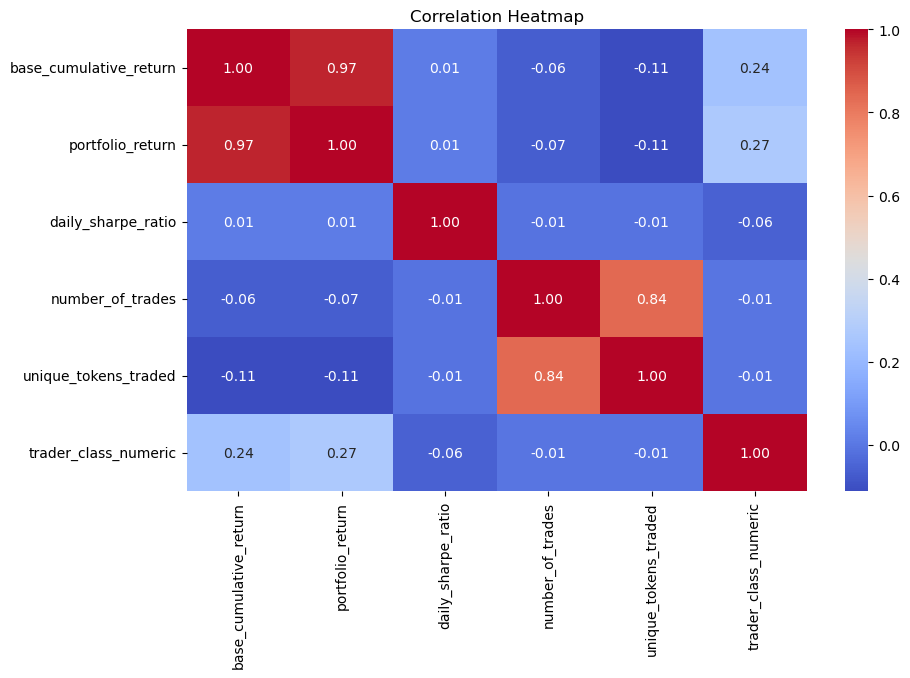

: 

: 

: 

In [ ]:
import seaborn as sns 

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cor, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


# Classifier Model

In [ ]:
df_cleaned.dtypes

day                       datetime64[ns]
user_address                      object
base_cumulative_return           float64
portfolio_return                 float64
daily_sharpe_ratio               float64
trader_class                    category
number_of_trades                 float64
unique_tokens_traded             float64
trader_class_numeric                int8
dtype: object

: 

: 

: 

In [ ]:
numeric = df_cleaned.select_dtypes(include=['number'])
#numeric

: 

: 

: 

In [ ]:
features = ['base_cumulative_return', 'portfolio_return', 
            'daily_sharpe_ratio', 'number_of_trades', 'unique_tokens_traded']

: 

: 

: 

In [ ]:
target = 'trader_class_numeric'

: 

: 

: 

In [ ]:
df_cleaned['portfolio_return'].describe()

count    14709.000000
mean        95.324347
std         39.219334
min         -2.588934
25%         75.534598
50%         99.950774
75%        114.742259
max        231.557553
Name: portfolio_return, dtype: float64

: 

: 

: 

In [ ]:
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score


: 

: 

: 

In [ ]:
#Data Processing
#Separating the features from the target variable.

X = df_cleaned[features]
y = df_cleaned[target]

: 

: 

: 

In [ ]:
#Normalize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

: 

: 

: 

### Split the data

In [ ]:
#Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



: 

: 

: 

# Train the Logistic Regression Model

In [ ]:
#Train the logistic Regression Model
log_reg = LogisticRegression(solver='lbfgs')
# solver='lbfgs' is the default solver in newer version of sklearn
log_reg.fit(X_train, y_train)

NameError: name 'LogisticRegression' is not defined

: 

: 

: 

# Predict on the test set

In [ ]:
#predict on the test set
y_pred = log_reg.predict(X_test)

: 

: 

: 

# Evaluate the Model

##### Confusion Matrix

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 840    2    1]
 [  44 1408    0]
 [   3    0  644]]


: 

: 

: 

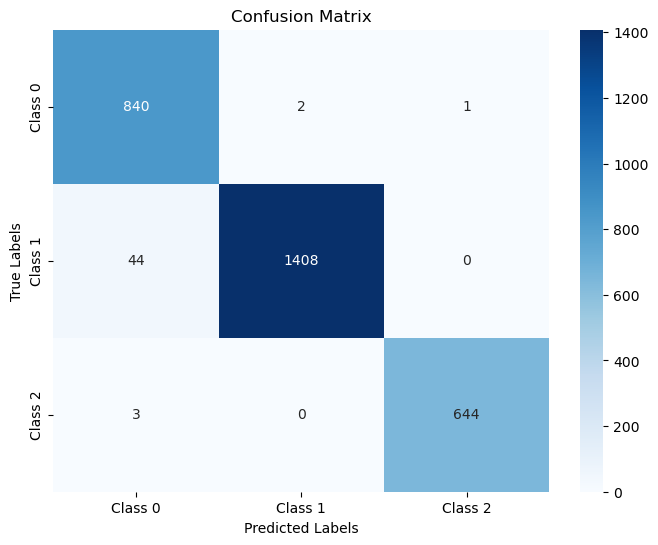

: 

: 

: 

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Result: Correct predictions (True Positives for each class).

#### Classification Report

In [ ]:
report = classification_report(y_test, y_pred,output_dict=True)
print("Classification Report:")
print(report)

Classification Report:
{'0': {'precision': 0.9470124013528749, 'recall': 0.99644128113879, 'f1-score': 0.9710982658959537, 'support': 843.0}, '1': {'precision': 0.9985815602836879, 'recall': 0.9696969696969697, 'f1-score': 0.983927323549965, 'support': 1452.0}, '2': {'precision': 0.9984496124031008, 'recall': 0.9953632148377125, 'f1-score': 0.9969040247678018, 'support': 647.0}, 'accuracy': 0.9830047586675731, 'macro avg': {'precision': 0.9813478580132212, 'recall': 0.9871671552244908, 'f1-score': 0.9839765380712402, 'support': 2942.0}, 'weighted avg': {'precision': 0.9837759276333088, 'recall': 0.9830047586675731, 'f1-score': 0.9831051040005458, 'support': 2942.0}}


: 

: 

: 

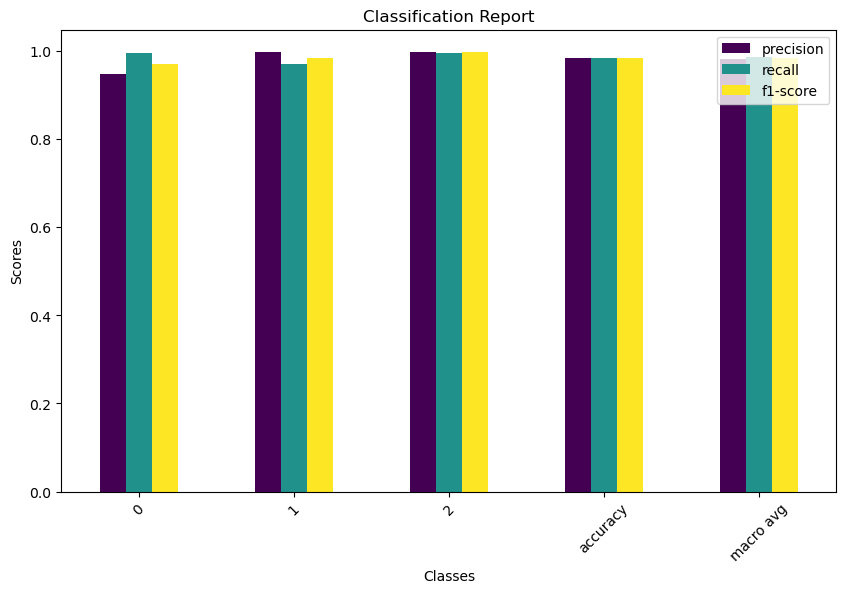

: 

: 

: 

In [ ]:
# Convert the dictionary to a DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Plot the precision, recall, and f1-score
report_df = report_df.iloc[:-1, :-1]  # Exclude support and accuracy row/column
report_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Classification Report")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.show()

#### Accuracy Score

In [ ]:
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9830047586675731


: 

: 

: 

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


: 

: 

: 

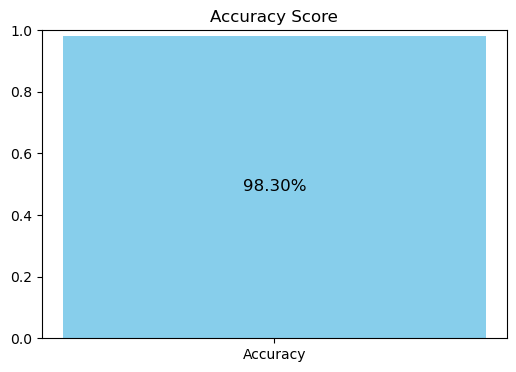

: 

: 

: 

In [ ]:
# Display accuracy in a plot
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy], color="skyblue")
plt.ylim(0, 1)  # Scale from 0 to 1
plt.title("Accuracy Score")
plt.text(0, accuracy / 2, f"{accuracy:.2%}", ha="center", va="center", fontsize=12)
plt.show()

#### AUROC Curve

In [ ]:
# Calculate AUROC
# Get predicted probabilities for all classes
y_pred_multi = log_reg.predict_proba(X_test)

# Calculate AUROC for multi-class classification
auroc_multi = roc_auc_score(y_test, y_pred_multi, multi_class='ovr')
print(f"Area Under the ROC Curve (AUROC) for Multi-Class: {auroc_multi:.2f}")

Area Under the ROC Curve (AUROC) for Multi-Class: 1.00


: 

: 

: 

# Interpret the Model

#### Logistic regression provides coefficients that indicate feature importance

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)

                  Feature  Coefficient
0  base_cumulative_return     1.924936
1        portfolio_return     1.117040
3        number_of_trades     0.356265
2      daily_sharpe_ratio     0.274571
4    unique_tokens_traded     0.164977


: 

: 

: 

# Randomized Search for Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_distributions = {
    'C': np.logspace(-4, 4, 20),  # Exponential range for regularization
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Display best parameters and accuracy
print("Best Parameters (Random Search):", random_search.best_params_)
print(f"Best Cross-Validation Accuracy (Random Search): {random_search.best_score_:.2f}")

# Use the best estimator for predictions
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

# Evaluate the tuned model
print("\nConfusion Matrix (Tuned Model - Random Search):")
print(confusion_matrix(y_test, y_pred_random))
print("\nClassification Report (Tuned Model - Random Search):")
print(classification_report(y_test, y_pred_random))
print(f"\nAccuracy (Tuned Model - Random Search): {accuracy_score(y_test, y_pred_random):.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/olaoluwatunmise/miniconda3/envs/flipside/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipside/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipside/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipside/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/olaoluwatunmise/miniconda3/envs/flipside/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of

Best Parameters (Random Search): {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 10000.0}
Best Cross-Validation Accuracy (Random Search): 1.00

Confusion Matrix (Tuned Model - Random Search):
[[ 835    8    0]
 [   0 1452    0]
 [   0    0  647]]

Classification Report (Tuned Model - Random Search):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       843
           1       0.99      1.00      1.00      1452
           2       1.00      1.00      1.00       647

    accuracy                           1.00      2942
   macro avg       1.00      1.00      1.00      2942
weighted avg       1.00      1.00      1.00      2942


Accuracy (Tuned Model - Random Search): 1.00


: 

: 

: 